In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=0.01, eps=0.05, embedtxt=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True, na_values='empty')

INFO:profiler.utility:[0.006402015686035156] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address1': ['equal'], 'City

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.dataset:updated types of State to 'text'
INFO:profiler.dataset:updated operators of State to ['equal']
INFO:profiler.dataset:updated types of EmergencyService to 'text'
INFO:profiler.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hospi

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[0.13375401496887207] Load Embedding start

INFO:profiler.utility:[0.22439789772033691] Load Embedding execution time: 0.09064388275146484



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [6]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[0.23110485076904297] Create Training Data start

INFO:profiler.transformer:needs multiplier = 165 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 165, and the bound is 0.00007305
INFO:profiler.transformer:Draw Pairs
100%|██████████| 17/17 [00:00<00:00, 84.22it/s]
INFO:profiler.transformer:Number of training samples: 169830
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0314
INFO:profiler.utility:[5.802129745483398] Create Training Data execution time: 5.5710248947143555



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [14]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, infer_order=True)

INFO:profiler.utility:[73.34084701538086] Learn Structure start

INFO:profiler.learner:use threshold 0.0426
INFO:profiler.utility:[73.53189396858215] Learn Structure execution time: 0.19104695320129395



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [15]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[73.79005479812622] Get Dependencies start

INFO:profiler.utility:[73.88000512123108] Get Dependencies execution time: 0.0899503231048584



ProviderNumber -> ZipCode (0.17213374689918806)
ProviderNumber,ZipCode -> HospitalOwner (0.12910066730516329)
ProviderNumber,ZipCode,HospitalOwner -> PhoneNumber (0.04768956418289933)
ProviderNumber,ZipCode,HospitalOwner,PhoneNumber -> HospitalName (0.031342355903611854)
ProviderNumber,ZipCode,HospitalOwner,PhoneNumber,HospitalName -> Address1 (0.031099798716795406)
ProviderNumber,ZipCode,HospitalOwner,PhoneNumber,HospitalName,Address1 -> City (0.0486322515139261)
ProviderNumber,ZipCode,HospitalOwner,PhoneNumber,HospitalName,Address1,City -> CountyName (0.05227489783396641)
MeasureCode -> Stateavg (0.03144005739800861)
MeasureCode,Stateavg -> Condition (0.20616863100827792)
PhoneNumber,HospitalName,CountyName -> EmergencyService (0.142193007421046)


## 5. Visualization

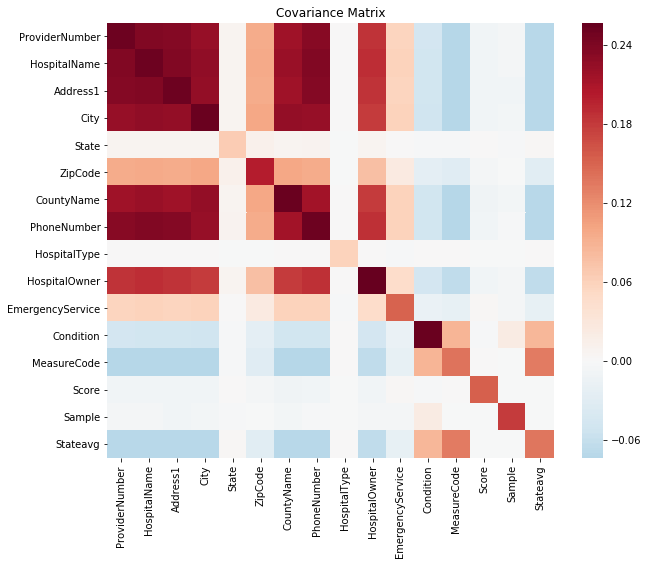

In [16]:
pf.session.visualize_covariance()

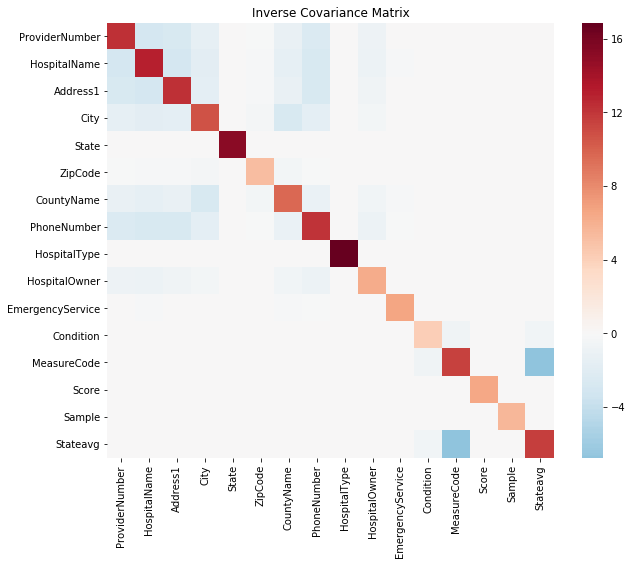

In [17]:
pf.session.visualize_inverse_covariance()

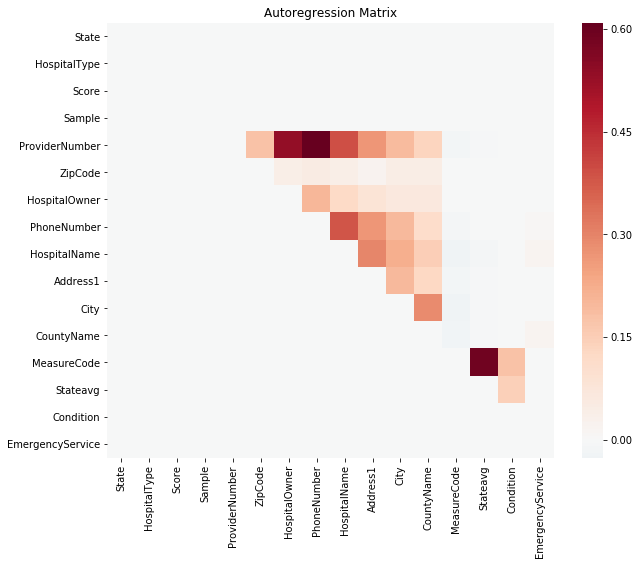

In [18]:
pf.session.visualize_autoregression()

In [19]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.006402,start: Load Data,0.000000
1,0.083199,end: Load Data,0.076797
2,0.133754,start: Load Embedding,0.000000
3,0.224398,end: Load Embedding,0.090644
4,0.231105,start: Create Training Data,0.000000
5,5.802130,end: Create Training Data,5.571025
6,5.808462,start: Learn Structure,0.000000
7,5.843111,end: Learn Structure,0.034649
8,5.850562,start: Get Dependencies,0.000000
9,5.926464,end: Get Dependencies,0.075902
